In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import jax.numpy as jnp
import jax
from functools import partial

In [2]:
import lib

In [3]:
from lib import Neuron, Xs_Generator


class Neuron3_test(lib.Neuron3):
    def __init__(self, n_synapses, n_dendrites, bias, kappa, ndR, n_u, seed=42) -> None:
        super().__init__(n_synapses, n_dendrites, bias, kappa, ndR, seed)
        self.n_u = n_u

    def get_first_n_overlaps(self, w, x):
        "get votes/evidence to decide whether pattern x is familiar or unfamiliar"
        x = jnp.atleast_2d(x)
        f1 = lambda x: (w@x.T)[:, 0] # for 1d x
        f2 = lambda x: jnp.sum(w*x, axis=-1) # for 2d x
        # when input x is 1d, f1 runs faster than f2, because broadcast operation is not needed in f1. 
        overlaps = jax.lax.cond((x.shape)[0]==1, f1, f2, x) # dim=(nd, )
        high_overlaps, updated_idx = jax.lax.top_k(overlaps, self.n_u)
        return high_overlaps
    
class Simulation_Run2_test(lib.Simulation_Run2):
    def __init__(self, neuron: Neuron3_test, xs_gen: Xs_Generator, decay_steps=500, initial_steps=500, n_tested_patterns=100, refresh_every=1000, seed=42) -> None:
        super().__init__(neuron, xs_gen, decay_steps, initial_steps, n_tested_patterns, refresh_every, seed)
        self.votes_record = np.zeros((n_tested_patterns, neuron.n_u, decay_steps+n_tested_patterns))

    @partial(jax.jit, static_argnums=(0, ))
    def _update_and_get_votes(self, w, latent_var, x, x0s):
        w, latent_var = self.neuron.update_fun(w, x, latent_var)
        votes = jax.vmap(self.neuron.get_first_n_overlaps, in_axes=(None, 0))(w, x0s) # dim=(n_tested_patterns, )
        return w, latent_var, votes
    



In [4]:
ns=200
nd=200
bias = 2.32635
ndR = 13
kappa = 0.6774
n_u = 20
# n_votes = 300
# vote_th = 2.32635
# la = 0.445556
# beta = 11.5

decay_steps = 15000
n_tested_patterns = 500
initial_steps = 5000

seed = 238238
rng = np.random.default_rng(seed)

# neuron = lib.Neuron10_2(n_synapses=ns, n_dendrites=nd, bias=bias, kappa=kappa, ndR=ndR, beta=beta, seed=rng.integers(100000))
neuron2 = Neuron3_test(n_synapses=ns, n_dendrites=nd, bias=bias, kappa=kappa, ndR=ndR, n_u=n_u, seed=rng.integers(100000))
# neuron = lib.Neuron4_2(n_synapses=ns, n_dendrites=nd, bias=bias, kappa=kappa, la=la, n_votes=n_votes, seed=rng.integers(100000))

xs_gen = lib.Xs_Generator1(nd, ns, normalized_len=np.sqrt(ns), seed=rng.integers(100000))

simulation_run2 = Simulation_Run2_test(neuron2, xs_gen, decay_steps=decay_steps, initial_steps=initial_steps, n_tested_patterns=n_tested_patterns, refresh_every=500, seed=rng.integers(100000))

I0000 00:00:1696849645.883638   13716 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [5]:
simulation_run2.run()

  0%|          | 0/15500 [00:00<?, ?it/s]

100%|██████████| 15500/15500 [01:03<00:00, 244.92it/s]


In [6]:
simulation_run2.votes_record.shape

(500, 20, 15500)

In [7]:
u_record = simulation_run2.votes_record[..., :decay_steps]

In [8]:
u_center_list = np.mean(u_record[:, :3, :], axis=1)
lower99_trial_idx_list = np.argsort(u_center_list, axis=0)[int(n_tested_patterns*0.01)]
upper99_trial_idx_list = np.argsort(u_center_list, axis=0)[int(n_tested_patterns*0.99)]

Text(0.5, 0, 'time')

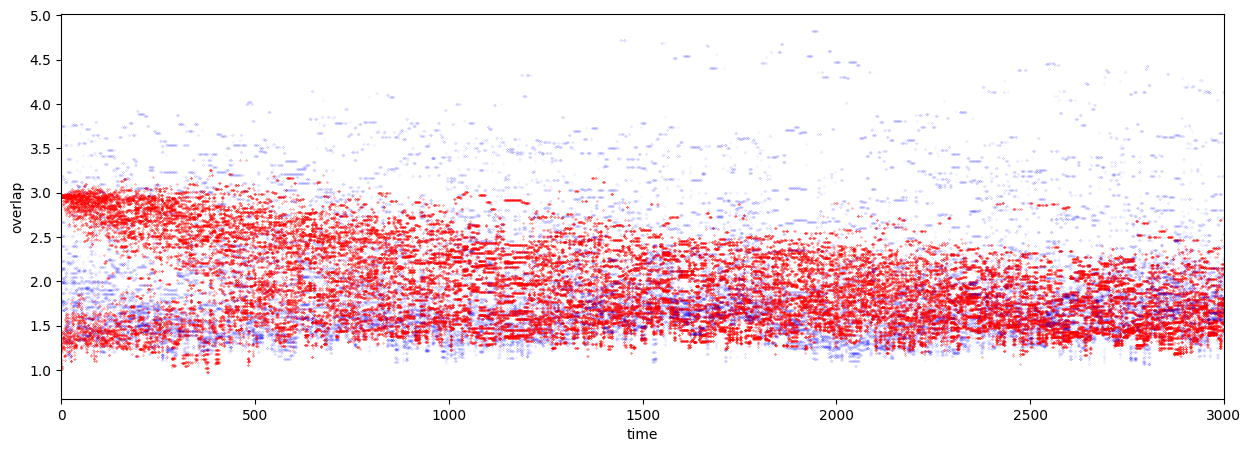

In [9]:
plt.figure(figsize=(15, 5))
upper_start = 10000

for i in range(n_u):
    plt.scatter(np.arange(upper_start, decay_steps)-upper_start, u_record[upper99_trial_idx_list[upper_start:], i, np.arange(upper_start, decay_steps)], s=0.002, c="blue")
    plt.scatter(np.arange(decay_steps), u_record[lower99_trial_idx_list, i, np.arange(decay_steps)], s=0.05, c="red")

plt.xlim(0, 3000)
# plt.ylim(1, 5)
plt.ylabel("overlap")
plt.xlabel("time")

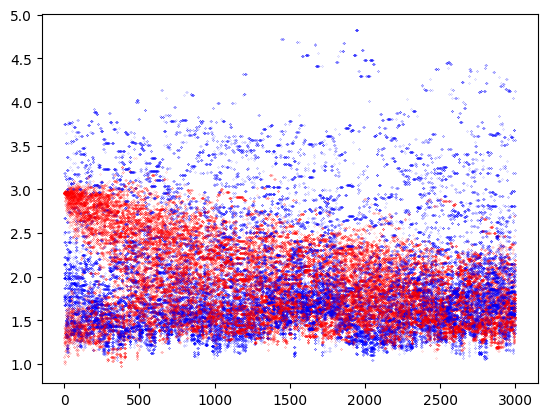

In [10]:
n_steps = 3000
t1_start = 00
t2_start = 10000
for i in range(n_u):
    plt.scatter(np.arange(n_steps), u_record[upper99_trial_idx_list[t2_start:t2_start+n_steps], i, np.arange(t2_start, t2_start+n_steps)], s=0.01, c="blue")
    plt.scatter(np.arange(n_steps), u_record[lower99_trial_idx_list[t1_start:t1_start+n_steps], i, np.arange(t1_start, t1_start+n_steps)], s=0.01, c="red")

# for t in range(t1_start, t1_start + n_steps):
#     plt.scatter(np.arange(n_u), u_record[lower99_trial_idx_list[t], :, t], c="red")
# for t in range(t2_start, t2_start+n_steps):
#     plt.scatter(np.arange(n_u), u_record[upper99_trial_idx_list[t], :, t], c="blue")

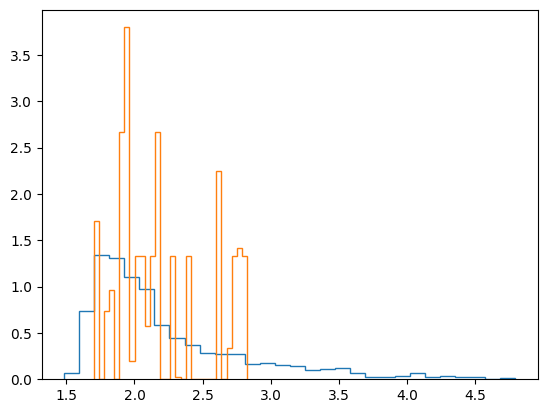

In [34]:
n_steps1 = 100
n_steps = 4000
t1_start = 1700
t2_start = 10000
plt.hist(u_record[upper99_trial_idx_list[t2_start:t2_start+n_steps], :, np.arange(t2_start, t2_start+n_steps)].reshape((-1, )), bins=30, histtype="step", density=True);
plt.hist(u_record[lower99_trial_idx_list[t1_start:t1_start+n_steps1], :, np.arange(t1_start, t1_start+n_steps1)].reshape((-1, )), bins=30, histtype="step", density=True);

In [17]:
def fun1(x):
    b = 2.32635
    return (x-b>0)

# def fun1(x):
#     b = 3.
#     return (x-b)*(x-b>0)

In [18]:
votes_mean = np.sum(fun1(u_record), axis=1)
votes_upper99 = np.sort(votes_mean, axis=0)[int(n_tested_patterns*0.99)]
votes_lower99 = np.sort(votes_mean, axis=0)[int(n_tested_patterns*0.01)]
votes_mean = np.mean(votes_mean, axis=0)

(0.0, 1000.0)

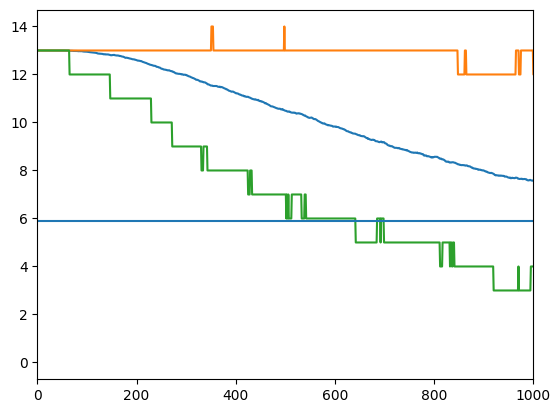

: 

In [19]:
plt.plot(votes_mean)
plt.plot(votes_upper99)
plt.plot(votes_lower99)
plt.hlines(np.mean(votes_upper99[-4000:]), 0, len(votes_mean))

plt.xlim(0, 1000)